<a href="https://colab.research.google.com/github/Theobano/Tesla-Stock-chart/blob/main/Tesla_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install yfinance
!pip install mplfinance


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import gridspec
import mplfinance as mpf
import seaborn as sns

In [20]:
tesla = yf.Ticker("TSLA")

In [42]:
data_or = tesla.history(period = "max")

In [43]:
len(data_or)

2930

In [44]:
data_or['MA50'] = data_or[['Close']].rolling(50).mean()
data_or['MA200'] = data_or[['Close']].rolling(200).mean()


k = data_or['Close'].ewm(span=12, adjust=False, min_periods=12).mean()
# Get the 12-day EMA of the closing price
d = data_or['Close'].ewm(span=26, adjust=False, min_periods=26).mean()
# Subtract the 26-day EMA from the 12-Day EMA to get the MACD
macd = k - d
# Get the 9-Day EMA of the MACD for the Trigger line
macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()
# Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
macd_h = macd - macd_s
# Add all of our new values for the MACD to the dataframe
data_or['macd'] = data_or.index.map(macd)
data_or['macd_h'] = data_or.index.map(macd_h)
data_or['macd_s'] = data_or.index.map(macd_s)

In [45]:
n = 14


def rma(x, n, y0):
    a = (n-1) / n
    ak = a**np.arange(len(x)-1, -1, -1)
    return np.r_[np.full(n, np.nan), y0, np.cumsum(ak * x) / ak / n + y0 * a**np.arange(1, len(x)+1)]

data_or['change'] = data_or['Close'].diff()
data_or['gain'] = data_or.change.mask(data_or.change < 0, 0.0)
data_or['loss'] = -data_or.change.mask(data_or.change > 0, -0.0)
data_or['avg_gain'] = rma(data_or.gain[n+1:].to_numpy(), n, np.nansum(data_or.gain.to_numpy()[:n+1])/n)
data_or['avg_loss'] = rma(data_or.loss[n+1:].to_numpy(), n, np.nansum(data_or.loss.to_numpy()[:n+1])/n)
data_or['rs'] = data_or.avg_gain / data_or.avg_loss
data_or['rsi_14'] = 100 - (100 / (1 + data_or.rs))

In [46]:
data_or.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA50,MA200,macd,macd_h,macd_s,change,gain,loss,avg_gain,avg_loss,rs,rsi_14
Date,,,,,,,,,,,,,,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,93831500,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-06-30,5.158,6.084,4.660,4.766,85935500,0,0.0,NaN,NaN,NaN,NaN,NaN,-0.012,0.0,0.012,NaN,NaN,NaN,NaN
2010-07-01,5.000,5.184,4.054,4.392,41094000,0,0.0,NaN,NaN,NaN,NaN,NaN,-0.374,0.0,0.374,NaN,NaN,NaN,NaN
2010-07-02,4.600,4.620,3.742,3.840,25699000,0,0.0,NaN,NaN,NaN,NaN,NaN,-0.552,0.0,0.552,NaN,NaN,NaN,NaN
2010-07-06,4.000,4.000,3.166,3.222,34334500,0,0.0,NaN,NaN,NaN,NaN,NaN,-0.618,0.0,0.618,NaN,NaN,NaN,NaN


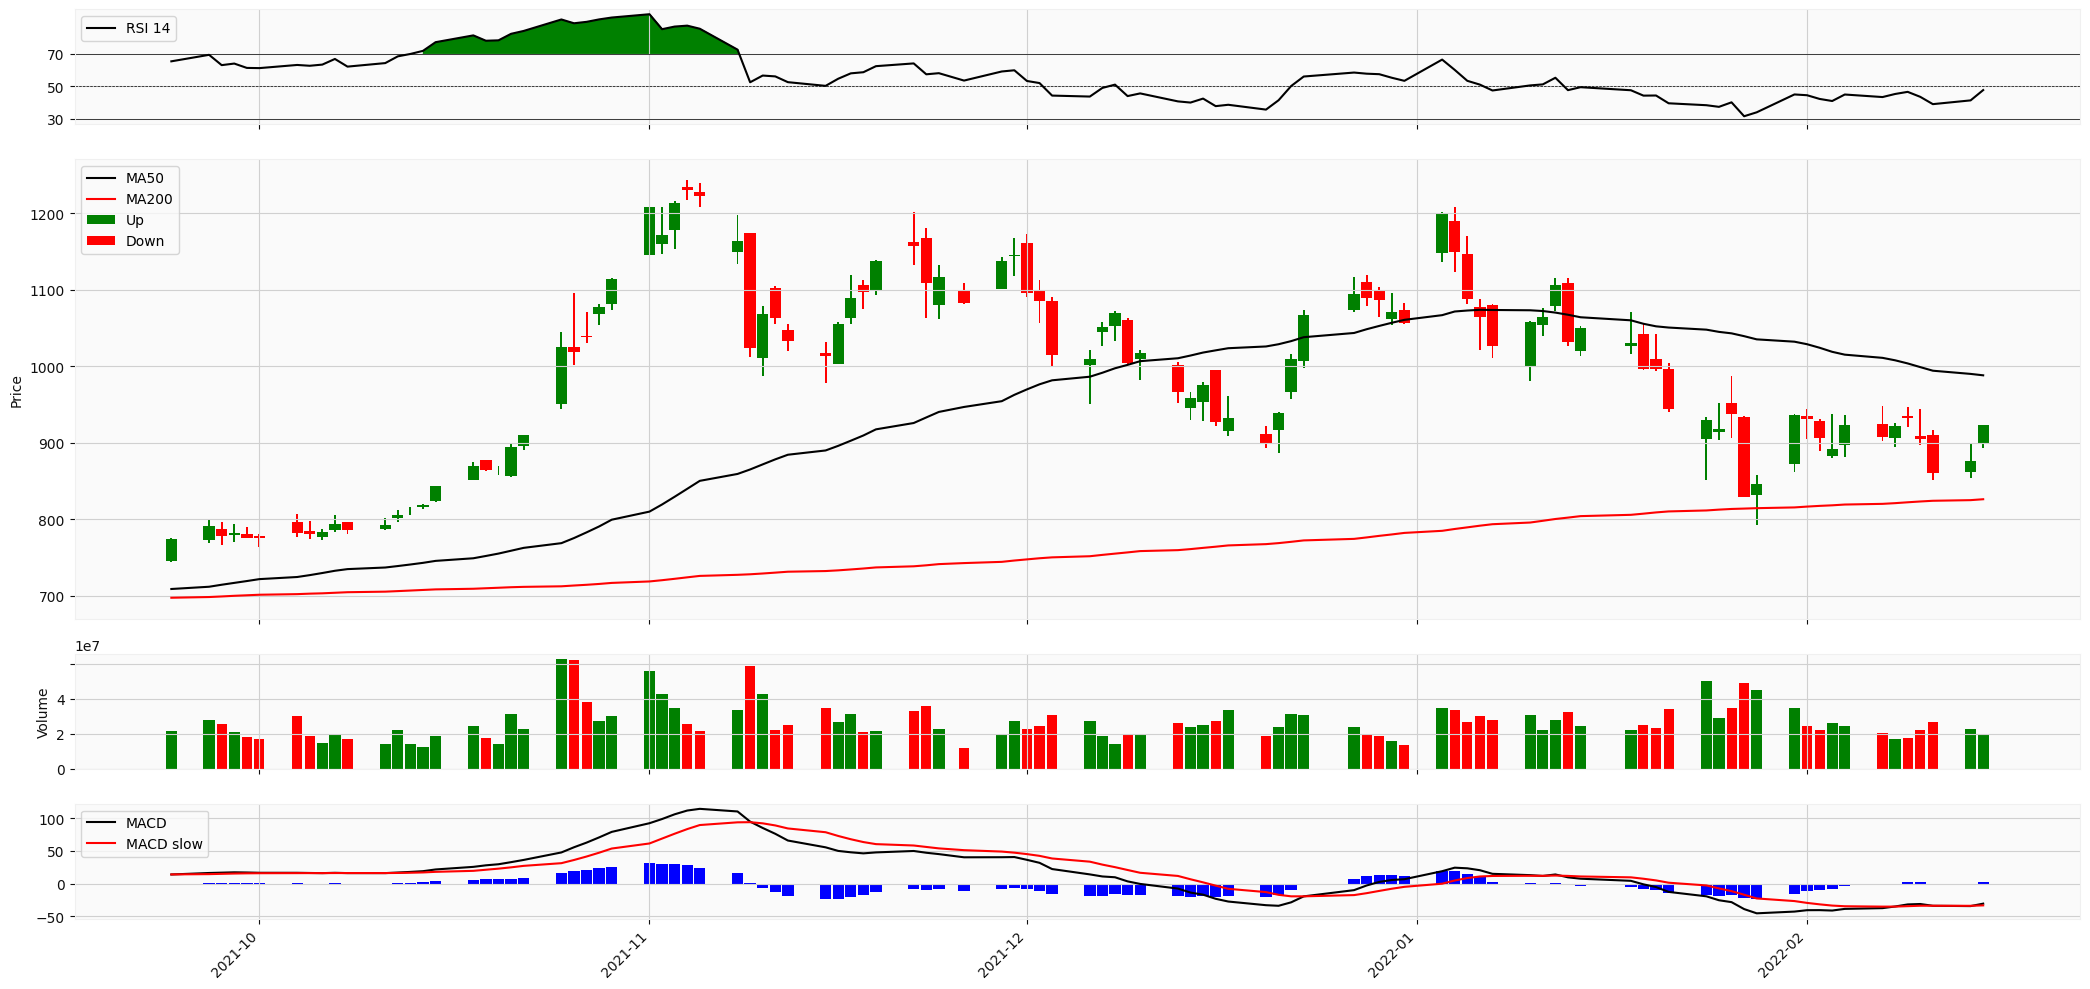

In [73]:
start = len(data_or) - 100
stop = len(data_or)

window_start = min(start, len(data_or))
window_stop = min(stop, len(data_or))

data = data_or[window_start:window_stop]


fig = plt.figure(figsize = (21,10))
# set height ratios for subplots
gs = gridspec.GridSpec(4, 1, height_ratios=[1, 4, 1, 1]) 

# THe first subplot
ax0 = plt.subplot(gs[0])
ax0.plot(data.index, data.rsi_14, color = "black", label = "RSI 14")
ax0.axhline(y=30, color = "black", linewidth = .5)
ax0.axhline(y=50, color = "black", linestyle = "dashed", linewidth = .5)
ax0.axhline(y=70, color = "black", linewidth = .5)
ax0.fill_between(data.index, data.rsi_14, 70, where = data.rsi_14>=70, color = "green")
ax0.fill_between(data.index, data.rsi_14, 30, where = data.rsi_14<=30, color = "green")

ax0.set_yticks([30, 50, 70])
ax0.legend(loc = "upper left")



# the second subplot
ax1 = plt.subplot(gs[1])
# log scale for axis Y of the first subplot
ax1.set_yscale("linear")


#define width of candlestick elements
width = .9
width2 = .15

#define up and down prices
up = data[data.Close>=data.Open]
down = data[data.Close<data.Open]

#define colors to use
col1 = 'green'
col2 = 'red'

#plot up prices
line00 = ax1.bar(up.index,up.Close-up.Open,width,bottom=up.Open,color=col1, label = "Up")
ax1.bar(up.index,up.High-up.Close,width2,bottom=up.Close,color=col1)
ax1.bar(up.index,up.Low-up.Open,width2,bottom=up.Open,color=col1)

#plot down prices
line01 = ax1.bar(down.index,down.Close-down.Open,width,bottom=down.Open,color=col2, label = "Down")
ax1.bar(down.index,down.High-down.Open,width2,bottom=down.Open,color=col2)
ax1.bar(down.index,down.Low-down.Close,width2,bottom=down.Close,color=col2)
ax1.plot(data.index, data.MA50, color = "black", label = "MA50")
ax1.plot(data.index, data.MA200, color = "red", label = "MA200")
ax1.set_ylabel("Price")
# put legend on second subplot
ax1.legend( loc='upper left')




# the third subplot
# shared axis X
ax2 = plt.subplot(gs[2], sharex = ax0)
#plot up prices
line10 = ax2.bar(up.index,up.Volume,color=col1, width = 0.9)

#plot down prices
line11 = ax2.bar(down.index,down.Volume,color=col2)

# remove last tick label for the second subplot
yticks = ax2.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)
ax2.set_ylabel("Volume")



# the fourth subplot

ax3 = plt.subplot(gs[3], sharex = ax0)
ax3.bar(data.index,data.macd_h,color="blue", width = 0.9)
ax3.plot(data.index, data.macd, color = "black", label = "MACD")
ax3.plot(data.index, data.macd_s, color = "red", label = "MACD slow")

ax3.legend(loc = "upper left")


plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')


# reduce vertical gap between subplots
plt.subplots_adjust(hspace=.2)
plt.tight_layout()
plt.savefig("Tesla series.png")
plt.show()